## Detecting Myocardial Infarction

The method and model are based on this article : https://arxiv.org/abs/1805.00794

### Let's start with some imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%config IPCompleter.greedy=True

### Fetching data

In [3]:
df_mitbih_train = pd.read_csv('data/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('data/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

df_ptbdb_normal = pd.read_csv('data/ptbdb_normal.csv', header=None)
df_ptbdb_abnormal = pd.read_csv('data/ptbdb_abnormal.csv', header=None)
df_ptbdb = pd.concat([df_ptbdb_normal, df_ptbdb_abnormal], axis=0)

print(df_mitbih.info())
print(df_ptbdb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14552 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 21.0 MB
None


The MITBIH dataset is constituted of 109446 beats, labeled with 5 different classes : 

'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4

    N : Non-ecotic beats (normal beat) 

    S : Supraventricular ectopic beats 

    V : Ventricular ectopic beats

    F : Fusion Beats 

    Q : Unknown Beats

The PTBHB dataset is constituted of 14552 beats, labeled with two different classes : 

    '0' for normal beat
    '1' for abnormal beat (Myocardial infarction)

All the beats are recorded with 187 points. The shorter beats are padded with zeros to reach 187.

## Visualization of the dataset

In [4]:
# ptbdb
M_ptbdb = df_ptbdb.values
X_ptbdb = M_ptbdb[:,:-1]
y_ptbdb = M_ptbdb[:,-1]

# mitbih
M_mitbih = df_mitbih.values
X_mitbih = M_mitbih[:,:-1]
y_mitbih = M_mitbih[:,-1]

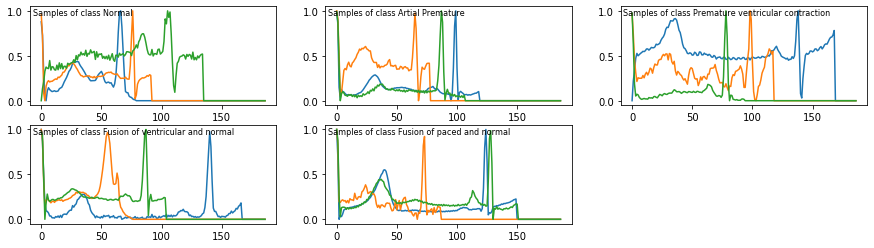

In [5]:
classes={0:"Normal",
         1:"Artial Premature",
         2:"Premature ventricular contraction",
         3:"Fusion of ventricular and normal",
         4:"Fusion of paced and normal"}
plt.figure(figsize=(15,4))
for i in range(0,5):
    plt.subplot(2,3,i + 1)
    all_samples_indexes = np.where(y_mitbih == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_mitbih[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc='left', fontdict={'fontsize':8}, x=0.01, y=0.85)


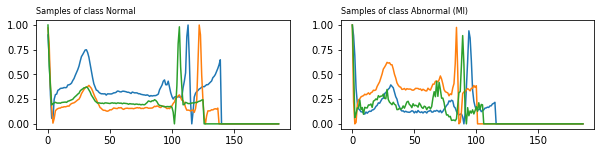

In [6]:
classes={0:"Normal", 1:"Abnormal (MI)"}
plt.figure(figsize=(10,2))
for i in range(0,2):
    plt.subplot(1,2,i + 1)
    all_samples_indexes = np.where(y_ptbdb == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_ptbdb[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc="left", fontdict={'fontsize':8})

In [7]:
repartition = df_mitbih[187].astype(int).value_counts()
print(repartition)

0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64


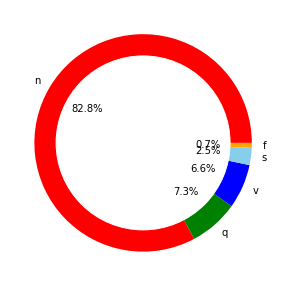

In [8]:
plt.figure(figsize=(5,5))
circle=plt.Circle( (0,0), 0.8, color='white')
plt.pie(repartition, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

The data repartition is very imbalanced : 83% of the data are normal beats.

## Model

In [9]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [10]:
input_shape = (187, 1)

def make_model(final_layer_size=5):
    I = Input(input_shape)
    C = Conv1D(filters=32, kernel_size=5)(I)

    C11 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(C)
    C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
    A11 = Add()([C, C12])
    R11 = Activation(activation='relu')(A11)
    M11 = MaxPool1D(pool_size=5, strides=2)(R11)

    C21 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M11)
    C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
    A21 = Add()([M11, C22])
    R21 = Activation(activation='relu')(A21)
    M21 = MaxPool1D(pool_size=5, strides=2)(R21)

    C31 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M21)
    C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
    A31 = Add()([M21, C32])
    R31 = Activation(activation='relu')(A31)
    M31 = MaxPool1D(pool_size=5, strides=2)(R31)

    C41 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M31)
    C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
    A41 = Add()([M31, C42])
    R41 = Activation(activation='relu')(A41)
    M41 = MaxPool1D(pool_size=5, strides=2)(R41)

    C51 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M41)
    C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
    A51 = Add()([M41, C52])
    R51 = Activation(activation='relu')(A51)
    M51 = MaxPool1D(pool_size=5, strides=2)(R51)

    F1 = Flatten()(M51)
    D1 = Dense(32)(F1)
    R1 = Activation(activation='relu')(D1)
    D2 = Dense(32)(R1)
    D3 = Dense(final_layer_size)(D2)

    O = Activation(activation='softmax')(D3)

    return Model(inputs=I, outputs=O)

model = make_model(final_layer_size=5)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
_____________

"For training the networks, we used Adam optimization method with the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999, respectively. Learning rate is decayed exponentially with the decay factor of 0.75 every 10000 iterations."

In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

### Detecting MI with ptbdb dataset only

In [12]:
n_classes = len(np.unique(y_ptbdb))
model_ptbdb = make_model(n_classes)

X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(X_ptbdb, y_ptbdb, test_size=0.15)

In [13]:
mc = tf.keras.callbacks.ModelCheckpoint('weights/ptbdb{epoch:08d}.h5', save_weights_only=True, period=5)
model_ptbdb.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
history = model_ptbdb.fit(np.expand_dims(X_train_ptbdb, axis=2), 
                          y_train_ptbdb, 
                          validation_split=0.15,
                          epochs=30,
                          batch_size=256,
                          callbacks=[mc])

Train on 10513 samples, validate on 1856 samples
Epoch 1/30
10513/10513 [==============================] - 12s 1ms/sample - loss: 0.5302 - acc: 0.7350 - val_loss: 0.5482 - val_acc: 0.7452
Epoch 2/30
10513/10513 [==============================] - 9s 830us/sample - loss: 0.3497 - acc: 0.8463 - val_loss: 0.3244 - val_acc: 0.8567
Epoch 3/30
10513/10513 [==============================] - 9s 884us/sample - loss: 0.2509 - acc: 0.8992 - val_loss: 0.2760 - val_acc: 0.8933
Epoch 4/30
10513/10513 [==============================] - 9s 896us/sample - loss: 0.1852 - acc: 0.9273 - val_loss: 0.1969 - val_acc: 0.9240
Epoch 5/30
10513/10513 [==============================] - 10s 971us/sample - loss: 0.1312 - acc: 0.9518 - val_loss: 0.1180 - val_acc: 0.9558
Epoch 6/30
10513/10513 [==============================] - 10s 905us/sample - loss: 0.1204 - acc: 0.9542 - val_loss: 0.1903 - val_acc: 0.9305
Epoch 7/30
10513/10513 [==============================] - 9s 830us/sample - loss: 0.1094 - acc: 0.9602 - val_l

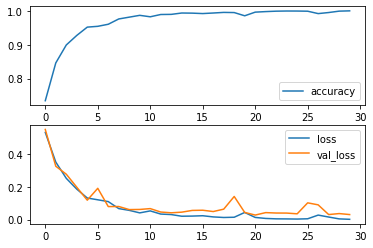

In [78]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.legend(["accuracy"])
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend(["loss", "val_loss"])
plt.show()

The loss converges at around 20 epochs.

In [14]:
model_ptbdb.load_weights("weights/ptbdb00000030.h5")

In [15]:
results = model_ptbdb.evaluate(np.expand_dims(X_test_ptbdb, axis=2), y_test_ptbdb, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

2183/2183 [==============================] - 0s 168us/sample - loss: 0.0114 - acc: 0.9982
The accuracy on the testing set is 99.8%


In [16]:
unique, counts = np.unique(y_test_ptbdb, return_counts=True)
print(f"The testing set contains {counts[0]} normal recordings and {counts[1]} with myocardial infarction.\nLet's compute the confusion matrix.")

The testing set contains 615 normal recordings and 1568 with myocardial infarction.
Let's compute the confusion matrix.


In [24]:
predictions = model_ptbdb.predict(np.expand_dims(X_test_ptbdb, axis=2))
confusion_matrix = tf.confusion_matrix(y_test_ptbdb, predictions[:,1] > 0.5)
sess = tf.Session()
with sess.as_default():
        cm = sess.run(confusion_matrix)
print(cm)

print(f"{cm[0][0]} / {counts[0]} MI were correctly classified")

print(f"{cm[1][1]} / {counts[1]} normal beats were correctly classified")

print(f"{cm[1][0]} beats were classified as MI")

print(f"{cm[0][1]} MI were classified as normal")

[[ 612    3]
 [   1 1567]]
612 / 615 MI were correctly classified
1567 / 1568 normal beats were correctly classified
1 beats were classified as MI
3 MI were classified as normal


### Detecting MI with the mitbih dataset and transfert learning

The research article suggests a training on the mitbih dataset with 5 output classes to detect high level features.

Then, this model is frozen and followed by two dense layers of size 32 trained on the ptbdb dataset. Let's try to implement this.

First, the 5 output classes model.

In [102]:
X_train_mitbih, X_test_mitbih, y_train_mitbih, y_test_mitbih = train_test_split(X_mitbih, y_mitbih, test_size=0.15)

In [103]:
n_classes_mitbih = len(np.unique(y_mitbih))
model_mitbih = make_model(n_classes_mitbih)
model_mitbih.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mc = tf.keras.callbacks.ModelCheckpoint('weights/mitbih{epoch:08d}.h5', save_weights_only=True, period=5)

In [32]:
history = model_mitbih.fit(np.expand_dims(X_train_mitbih, axis=2), 
                           y_train_mitbih, 
                           validation_split=0.15,
                           epochs=30,
                           batch_size=256,
                           callbacks=[mc])

Train on 79074 samples, validate on 13955 samples
Epoch 1/30
79074/79074 [==============================] - 70s 882us/sample - loss: 0.3288 - acc: 0.9061 - val_loss: 0.1611 - val_acc: 0.9591
Epoch 2/30
79074/79074 [==============================] - 79s 998us/sample - loss: 0.1316 - acc: 0.9641 - val_loss: 0.1115 - val_acc: 0.9684
Epoch 3/30
79074/79074 [==============================] - 76s 960us/sample - loss: 0.0949 - acc: 0.9739 - val_loss: 0.0797 - val_acc: 0.9766
Epoch 4/30
79074/79074 [==============================] - 70s 884us/sample - loss: 0.0777 - acc: 0.9778 - val_loss: 0.0680 - val_acc: 0.9791
Epoch 5/30
79074/79074 [==============================] - 69s 867us/sample - loss: 0.0686 - acc: 0.9805 - val_loss: 0.0691 - val_acc: 0.9823
Epoch 6/30
79074/79074 [==============================] - 67s 844us/sample - loss: 0.0584 - acc: 0.9827 - val_loss: 0.0699 - val_acc: 0.9804
Epoch 7/30
79074/79074 [==============================] - 67s 852us/sample - loss: 0.0540 - acc: 0.9840 

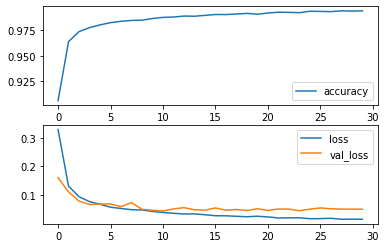

In [34]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.legend(["accuracy"])
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend(["loss", "val_loss"])
plt.show()

The model converges at around 10 epochs.

In [105]:
results = model_mitbih.evaluate(np.expand_dims(X_test_mitbih, axis=2), y_test_mitbih, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

16417/16417 [==============================] - 8s 497us/sample - loss: 0.0323 - acc: 0.9906
The accuracy on the testing set is 99.1%


Now, let's add the two dense layers with transfer learning.

In [82]:
model_mitbih.load_weights('weights/mitbih00000015.h5')
D1 = Dense(32)(model_mitbih.output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)

for layer in model.layers[:-3]:
    layer.trainable = False

for layer in model.layers[-3:]:
    layer.trainable = True
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [84]:
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2), 
                    y_train_ptbdb, 
                    validation_split=0.15,
                    epochs=5,
                    batch_size=128,)

Train on 10513 samples, validate on 1856 samples
Epoch 1/5
10513/10513 [==============================] - 7s 704us/sample - loss: 0.6004 - acc: 0.7091 - val_loss: 0.5808 - val_acc: 0.7188
Epoch 2/5
10513/10513 [==============================] - 6s 548us/sample - loss: 0.5776 - acc: 0.7220 - val_loss: 0.5786 - val_acc: 0.7188
Epoch 3/5
10513/10513 [==============================] - 6s 585us/sample - loss: 0.5766 - acc: 0.7220 - val_loss: 0.5782 - val_acc: 0.7188
Epoch 4/5
10513/10513 [==============================] - 6s 565us/sample - loss: 0.5750 - acc: 0.7220 - val_loss: 0.5788 - val_acc: 0.7188
Epoch 5/5
10513/10513 [==============================] - 5s 520us/sample - loss: 0.5744 - acc: 0.7220 - val_loss: 0.5752 - val_acc: 0.7188


In [90]:
print("Trainability of the layers \n")
for layer in model.layers:
    config = layer.get_config()
    print(f"{config['name']} : {config.get('trainable')}")

Trainability of the layers 

input_6 : None
conv1d_55 : False
conv1d_56 : False
conv1d_57 : False
add_25 : False
activation_35 : False
max_pooling1d_25 : False
conv1d_58 : False
conv1d_59 : False
add_26 : False
activation_36 : False
max_pooling1d_26 : False
conv1d_60 : False
conv1d_61 : False
add_27 : False
activation_37 : False
max_pooling1d_27 : False
conv1d_62 : False
conv1d_63 : False
add_28 : False
activation_38 : False
max_pooling1d_28 : False
conv1d_64 : False
conv1d_65 : False
add_29 : False
activation_39 : False
max_pooling1d_29 : False
flatten_5 : False
dense_69 : False
activation_40 : False
dense_70 : False
dense_71 : False
activation_41 : False
dense_96 : True
dense_97 : True
dense_98 : True


The results seem to be drastically worse than without transfer learning. I'm not sure how they reached 95,9% accuracy on the article. The model designed above seems correct, with only the last layers set as trainable.